## Problem Statement
Organization “Silara Retail”  is inviting the Developers and Data Scientists to build a high performing recommendation engine for their online retail portal.

They are making their last one year customer transaction (anonymized) data available. For the customers in test data, the participants need to recommend the next items that they are most likely to buy.

You are expected to build a high performing recommendation engine using any framework of your choice. You are encouraged to use IBM Watson Studio Apache spark based Jupyter notebook.

The model created should be readily consumable by the organization and hence you are expected to expose the model as API endpoint using any toolkit of their choice. It will be good to consider using Watson Machine Learning (WML) available through IBM Cloud.

## Read Data

In [1]:
# Import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')
import os
from textwrap import wrap
import re

# Set default fontsize and colors for graphs
SMALL_SIZE, MEDIUM_SIZE, BIG_SIZE = 10, 12, 20
plt.rc('font', size=MEDIUM_SIZE)       
plt.rc('axes', titlesize=BIG_SIZE)     
plt.rc('axes', labelsize=MEDIUM_SIZE)  
plt.rc('xtick', labelsize=MEDIUM_SIZE) 
plt.rc('ytick', labelsize=MEDIUM_SIZE) 
plt.rc('legend', fontsize=SMALL_SIZE)  
plt.rc('figure', titlesize=BIG_SIZE)
my_colors = 'rgbkymc'

# Disable scrolling for long output
from IPython.display import display, Javascript
disable_js = """
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}
"""
display(Javascript(disable_js))

np.random.seed(1)
#print(os.listdir('../input'))

<IPython.core.display.Javascript object>

In [2]:
# Read the input training data
input_data_dir = "C:\Study\DataSets\\MachineHack-predict-a-doctors-consultation-fees"
train_data_file = "Final_Train.xlsx"
train_data_path = os.path.join(input_data_dir, train_data_file)
train_data = pd.read_excel(train_data_path)
train_data.head(5)

,Qualification,Experience,Rating,Place,Profile,Miscellaneous_Info,Fees
0,"BHMS, MD - Homeopathy",24 years experience,100%,"Kakkanad, Ernakulam",Homeopath,"100% 16 Feedback Kakkanad, Ernakulam",100
1,"BAMS, MD - Ayurveda Medicine",12 years experience,98%,"Whitefield, Bangalore",Ayurveda,"98% 76 Feedback Whitefield, Bangalore",350
2,"MBBS, MS - Otorhinolaryngology",9 years experience,NaN,"Mathikere - BEL, Bangalore",ENT Specialist,NaN,300
3,"BSc - Zoology, BAMS",12 years experience,NaN,"Bannerghatta Road, Bangalore",Ayurveda,"Bannerghatta Road, Bangalore ₹250 Available on...",250
4,BAMS,20 years experience,100%,"Keelkattalai, Chennai",Ayurveda,"100% 4 Feedback Keelkattalai, Chennai",250


In [3]:
# Read the input training data
input_data_dir = "C:\Study\DataSets\\MachineHack-predict-a-doctors-consultation-fees"
test_data_file = "Final_test.xlsx"
test_data_path = os.path.join(input_data_dir, test_data_file)
test_data = pd.read_excel(test_data_path)
test_data.head(5)

,Qualification,Experience,Rating,Place,Profile,Miscellaneous_Info
0,MBBS,35 years experience,NaN,"Ghatkopar East, Mumbai",General Medicine,NaN
1,"MBBS, Diploma in Otorhinolaryngology (DLO)",31 years experience,NaN,"West Marredpally, Hyderabad",ENT Specialist,NaN
2,"MBBS, DDVL",40 years experience,70%,"KK Nagar, Chennai",Dermatologists,"70% 4 Feedback KK Nagar, Chennai"
3,BAMS,0 years experience,NaN,"New Ashok Nagar, Delhi",Ayurveda,NaN
4,"BDS, MDS - Conservative Dentistry & Endodontics",16 years experience,100%,"Kanakpura Road, Bangalore",Dentist,General Dentistry Conservative Dentistry Cosme...


In [4]:
train_data.shape, test_data.shape

((5961, 7), (1987, 6))

## Analyze Data

In [5]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5961 entries, 0 to 5960
Data columns (total 7 columns):
Qualification         5961 non-null object
Experience            5961 non-null object
Rating                2659 non-null object
Place                 5936 non-null object
Profile               5961 non-null object
Miscellaneous_Info    3341 non-null object
Fees                  5961 non-null int64
dtypes: int64(1), object(6)
memory usage: 326.1+ KB


In [6]:
train_data.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
Fees,5961.0,307.94464,190.920373,5.0,150.0,300.0,500.0,950.0


In [7]:
# Missing data
train_data.isna().sum()

Qualification            0
Experience               0
Rating                3302
Place                   25
Profile                  0
Miscellaneous_Info    2620
Fees                     0
dtype: int64

## Pre-process Data

In [8]:
# Function to normalize text

In [9]:
## Experience
#train_data['Experience'] = train_data.Experience.str.split(' ').str[0]
train_data['Experience_Yrs'] = train_data.Experience.map(lambda x : re.search('\d+', x).group())
train_data['Experience_Yrs'] = pd.to_numeric(train_data['Experience_Yrs'])
train_data.head()

,Qualification,Experience,Rating,Place,Profile,Miscellaneous_Info,Fees,Experience_Yrs
0,"BHMS, MD - Homeopathy",24 years experience,100%,"Kakkanad, Ernakulam",Homeopath,"100% 16 Feedback Kakkanad, Ernakulam",100,24
1,"BAMS, MD - Ayurveda Medicine",12 years experience,98%,"Whitefield, Bangalore",Ayurveda,"98% 76 Feedback Whitefield, Bangalore",350,12
2,"MBBS, MS - Otorhinolaryngology",9 years experience,NaN,"Mathikere - BEL, Bangalore",ENT Specialist,NaN,300,9
3,"BSc - Zoology, BAMS",12 years experience,NaN,"Bannerghatta Road, Bangalore",Ayurveda,"Bannerghatta Road, Bangalore ₹250 Available on...",250,12
4,BAMS,20 years experience,100%,"Keelkattalai, Chennai",Ayurveda,"100% 4 Feedback Keelkattalai, Chennai",250,20


In [10]:
## Experience
#train_data['Experience'] = train_data.Experience.str.split(' ').str[0]
test_data['Experience_Yrs'] = test_data.Experience.map(lambda x : re.search('\d+', x).group())
test_data['Experience_Yrs'] = pd.to_numeric(test_data['Experience_Yrs'])
test_data.head()

,Qualification,Experience,Rating,Place,Profile,Miscellaneous_Info,Experience_Yrs
0,MBBS,35 years experience,NaN,"Ghatkopar East, Mumbai",General Medicine,NaN,35
1,"MBBS, Diploma in Otorhinolaryngology (DLO)",31 years experience,NaN,"West Marredpally, Hyderabad",ENT Specialist,NaN,31
2,"MBBS, DDVL",40 years experience,70%,"KK Nagar, Chennai",Dermatologists,"70% 4 Feedback KK Nagar, Chennai",40
3,BAMS,0 years experience,NaN,"New Ashok Nagar, Delhi",Ayurveda,NaN,0
4,"BDS, MDS - Conservative Dentistry & Endodontics",16 years experience,100%,"Kanakpura Road, Bangalore",Dentist,General Dentistry Conservative Dentistry Cosme...,16


In [11]:
## Profile
train_data.Profile.value_counts()

Dentist             1397
General Medicine    1173
Dermatologists      1034
Homeopath            843
Ayurveda             786
ENT Specialist       728
Name: Profile, dtype: int64

In [22]:
## Qualification
train_data['Qualification_1'] = train_data.Qualification.map(lambda x : re.split(',', x)[0]).str.strip()
train_data['Qualification_1'] = train_data['Qualification_1'].str.split(' ').str[0].str.replace("[^a-zA-Z0-9]+",'').str.lower()
(train_data.Qualification_1.unique())

array(['bhms', 'bams', 'mbbs', 'bsc', 'bds', 'mds', 'diploma', 'dm', 'md',
       'mdsoral', 'get', 'phd', 'mrcps', 'ms', 'ddvl', 'dhms', 'gceh',
       'post', 'dnb', 'certification', 'fellowship', 'fage', 'bsam',
       'fnb', 'certificate', 'certified', '39', 'lceh', 'doctor',
       'diplomate', 'msc', 'advanced', 'fcps', 'gams', 'bums', 'mba',
       'training', 'pg', 'mch', 'ddv', 'bems', 'mrcs', 'ma', 'mph',
       'graduate', 'mrcpch', 'frcs', 'bac', 'bims', 'dvd', 'ayurvedic',
       'dhm', 'member', 'mrcgp', 'mrcp', 'cgo', 'pgd', 'dnhe',
       'doctorate', 'frguhs', 'm', 'frcp', 'cochlear', 'masters', 'pdcc',
       'ffdrcsi', 'mddvl', 'dgo'], dtype=object)

In [23]:
test_data['Qualification_1'] = test_data.Qualification.map(lambda x : re.split(',', x)[0]).str.strip()
test_data['Qualification_1'] = test_data['Qualification_1'].str.split(' ').str[0].str.replace("[^a-zA-Z0-9]+",'').str.lower()
#test_data.Qualification_1.value_counts().tail(5)
test_data.Qualification_1.unique()

array(['mbbs', 'bams', 'bds', 'md', 'bhms', 'ms', 'bsc', 'fellowship',
       'mds', 'lceh', 'dm', 'post', 'certificate', 'dvd', 'ddvl', 'dnb',
       'doctor', 'dhms', 'frcp', 'diploma', 'bsam', 'get', 'do', 'frcs',
       'fwfo', 'dms', 'mddvl', 'bpthbpt', 'fams', 'phd', 'ficd', 'dehm',
       'mrcgp', 'fpfa', 'mrcs', 'mrcp', 'certification', 'dpm'],
      dtype=object)

In [24]:
test_data[~test_data.Qualification_1.isin(train_data.Qualification_1.unique())]['Qualification_1'].count()

9

In [25]:
## Qualification
train_data['Qualification_2'] = train_data.Qualification.map(lambda x : re.split(',', x)[1] if x.count(',')>0 else 'NO_QUAL').str.strip()
train_data['Qualification_2'] = train_data['Qualification_2'].str.split(' ').str[0].str.strip().str.replace("[^a-zA-Z0-9]+",'').str.lower()
train_data.Qualification_2.unique()

array(['md', 'ms', 'bams', 'noqual', 'bds', 'mds', 'diploma', 'mf', 'dnb',
       'fellowship', 'ddvl', 'ibclc', 'mbbs', 'afih', 'm', 'dhms',
       'member', 'certificate', 'ddv', 'venereology', 'post', 'pgd',
       'morth', 'frcp', 'pg', 'msc', 'certification', 'mrcpch', 'frguhs',
       'mfds', 'dgo', 'dvd', 'bhms', 'phd', 'dm', 'mrcgp', 'postgraduate',
       'dpm', 'fage', 'division', 'fcps', 'masters', 'mcpuclausa', 'mrcp',
       'mba', 'dorl', 'ayurvedic', 'pghomlondon', 'cgo', 'do', 'mcip',
       'mdsoral', 'fcah', 'bpthbpt', 'pgnahi', 'ficd', 'bnys', 'dlo',
       'bsc', 'one', 'vd', 'fellow', 'mmed', 'diachgreece', 'mnams',
       'mrcs', 'comprehensive', 'pgcad', 'dya', 'mrcps', 'dnhe', 'pgcr',
       'certified', 'pgdhhm', 'mch', 'advanced', 'master', 'fcip', 'fcd',
       'dems', 'ma', 'lceh', 'ccedm', 'ccebdm', 'singapore', 'dortho',
       'basic', 'advance', 'pgde', 'bems', 'facc', 'fams', 'fsrh',
       'mfgdp', 'invisalign', 'pcad', 'frcs', 'pgdha', 'distance', 'dm

In [26]:
## Qualification
test_data['Qualification_2'] = test_data.Qualification.map(lambda x : re.split(',', x)[1] if x.count(',')>0 else 'NO_QUAL').str.strip()
test_data['Qualification_2'] = test_data['Qualification_2'].str.split(' ').str[0].str.strip().str.replace("[^a-zA-Z0-9]+",'').str.lower()
test_data.Qualification_2.unique()

array(['noqual', 'diploma', 'ddvl', 'mds', 'bams', 'fcd', 'ddv', 'md',
       'pg', 'mbbs', 'ms', 'phd', 'lceh', 'dgo', 'dm', 'dnb',
       'fellowship', 'bds', 'pgcr', 'frcs', 'postgraduate', 'mrcoguk',
       'fellow', 'yoga', 'pgdpc', 'pgd', 'mba', 'membership', 'pgdhhm',
       'mnams', 'certificate', 'doctor', 'venereology', 'post',
       'advanced', 'ficd', 'mrcps', 'dvd', 'dhms', 'ph', 'bhms', 'csd',
       'mch', 'fica', 'facc', 'fpfa', 'dlo', 'msc', 'implant', 'dnhe',
       'm', 'masters', 'mdsoral', 'pgdha', 'certification', 'dorl',
       'bsam', 'bsc', 'cgo', 'professional', 'frcp', 'dd', 'master',
       'doms', 'mmed', 'mrcgp', 'pgcad', 'fcps', 'panchkarma', 'dpm',
       'mdayurvedic', 'afih', 'dvl', 'mphil', 'bems', 'dph', 'graduate',
       'fdiab', 'fccp', 'pgdhsc', 'dpharm'], dtype=object)

In [27]:
test_data[~test_data.Qualification_2.isin(train_data.Qualification_2.unique())]['Qualification_2'].count()

18

In [41]:
## Numer of Qualification (Degrees)
train_data['Qualification_Total'] = train_data.Qualification.map(lambda x : x.count(',')+1)
train_data.Qualification_Total.value_counts()

2     2628
1     1962
3      995
4      257
5       84
6       23
7        6
9        3
8        2
10       1
Name: Qualification_Total, dtype: int64

In [42]:
## Numer of Qualification (Degrees)
test_data['Qualification_Total'] = test_data.Qualification.map(lambda x : x.count(',')+1)
test_data.Qualification_Total.value_counts()

2     889
1     609
3     366
4      87
5      28
6       5
17      1
9       1
7       1
Name: Qualification_Total, dtype: int64

In [28]:
# Place
train_data['Town'] = train_data.Place.str.split(',').str[0].str.strip(' ').str.replace("[^a-zA-Z0-9]+",'').str.lower()
train_data['Town'].value_counts().head()

hsrlayout       75
andheriwest     70
dwarka          68
banjarahills    64
mulundwest      54
Name: Town, dtype: int64

In [29]:
# Place
test_data['Town'] = test_data.Place.str.split(',').str[0].str.strip(' ').str.replace("[^a-zA-Z0-9]+",'').str.lower()
test_data['Town'].value_counts().head()

mulundwest     27
andheriwest    27
dwarka         26
whitefield     23
hsrlayout      22
Name: Town, dtype: int64

In [30]:
test_data[~test_data.Town.isin(train_data.Town.unique())]['Town'].count()

83

In [31]:
# Place
train_data['City'] = train_data.Place.str.split(',').str[1].str.strip().str.replace("[^a-zA-Z0-9]+",'').str.lower()
train_data['City'].value_counts().head()

bangalore    1258
mumbai       1219
delhi        1184
hyderabad     951
chennai       855
Name: City, dtype: int64

In [32]:
# Place
test_data['City'] = test_data.Place.str.split(',').str[1].str.strip().str.replace("[^a-zA-Z0-9]+",'').str.lower()
test_data['City'].value_counts().head()

bangalore    420
delhi        417
mumbai       389
hyderabad    333
chennai      287
Name: City, dtype: int64

In [33]:
test_data[~test_data.City.isin(train_data.City.unique())]['City'].count()

0

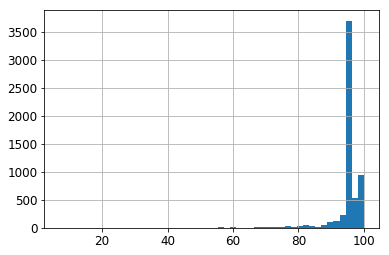

In [34]:
# Rating
train_data['Rating_Present'] = train_data["Rating"].notnull().astype('int')
test_data['Rating_Present'] = test_data["Rating"].notnull().astype('int')

train_data['Rating_Val'] = train_data.Rating.str.strip('%')
train_data['Rating_Val'] = pd.to_numeric(train_data['Rating_Val'])
train_rating_mean = train_data['Rating_Val'].mean()
train_data['Rating_Val'] = train_data['Rating_Val'].fillna(train_rating_mean)
train_data['Rating_Val'].hist(bins=50)
plt.show()

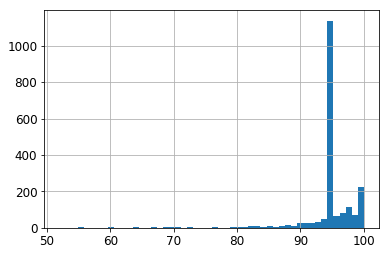

In [35]:
# Rating
test_data['Rating_Val'] = test_data.Rating.str.strip('%')
test_data['Rating_Val'] = pd.to_numeric(test_data['Rating_Val'])
test_data['Rating_Val'] = test_data['Rating_Val'].fillna(train_rating_mean)
test_data['Rating_Val'].hist(bins=50)
plt.show()

In [36]:
# Normalize ratings
train_data['Rating_Val'] = train_data['Rating_Val']/100
test_data['Rating_Val'] = test_data['Rating_Val']/100

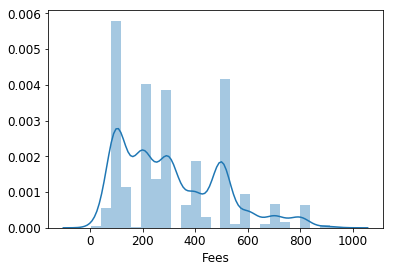

In [37]:
sns.distplot(train_data['Fees'])
plt.show()

## Build Model

In [43]:
features_1 = ['Experience_Yrs', 'Qualification_Total', 'Rating_Val', 'Rating_Present']
features_2 = ['City', 'Profile', 'Qualification_1', 'Qualification_2', 'Town']
features_X = features_1 + features_2

In [44]:
#train_data_2 = pd.get_dummies((train_data[features_2]).astype(str))
# Concat with keys then get dummies
temp = pd.get_dummies(pd.concat([train_data[features_2], test_data[features_2]],keys=[0,1]), columns=features_2)

# Selecting data from multi index and assigning them i.e
train_data_2, test_data_2 = temp.xs(0),temp.xs(1)
train_data_2.shape, test_data_2.shape

((5961, 1176), (1987, 1176))

In [45]:
from sklearn.preprocessing import PolynomialFeatures
poly = PolynomialFeatures(degree=10)
train_data_3 = poly.fit_transform(train_data[features_1])
train_data_3 = pd.DataFrame.from_records(train_data_3)

In [46]:
train_X = pd.concat([train_data[features_1], train_data_2], axis=1)
train_X.shape

(5961, 1180)

In [47]:
train_y = train_data['Fees']
train_y.shape

(5961,)

In [48]:
test_X = pd.concat([test_data[features_1], test_data_2], axis=1)
test_X.shape

(1987, 1180)

## Train Algorithms

In [49]:
def rmsle_score(y, y0):
    return (1 - np.sqrt(np.mean(np.square(np.log(y) - np.log(y0)))))

In [50]:
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_squared_log_error
from sklearn.linear_model import LinearRegression

lin_reg = LinearRegression()
lin_reg.fit(train_X, train_y)
predictions = lin_reg.predict(train_X)
lin_score = rmsle_score(train_y, predictions)
lin_score

0.43319337850197837

In [72]:
from sklearn.linear_model import LinearRegression
lin_reg = LinearRegression()

from sklearn.linear_model import Lasso
lasso = Lasso()

from sklearn.linear_model import ElasticNet
ela_net = ElasticNet()

from sklearn.linear_model import Ridge
ridge = Ridge()

from sklearn.tree import DecisionTreeRegressor
tree = DecisionTreeRegressor(splitter='random', max_features='auto')

from sklearn.ensemble import RandomForestRegressor
forest = RandomForestRegressor(n_estimators=100)

from sklearn.svm import SVR
svr_rbf = SVR(kernel='rbf')

from sklearn.svm import SVR
svr_lin = SVR(kernel='linear')

from sklearn.ensemble import GradientBoostingRegressor
gbr = GradientBoostingRegressor(learning_rate=0.5, n_estimators=500, max_depth=11, loss='huber')

from sklearn.neural_network import MLPRegressor
mlp_reg = MLPRegressor()

from sklearn.neighbors import KNeighborsRegressor
knn_reg = KNeighborsRegressor(n_neighbors=50, weights='distance', p=1)

In [37]:
model_name, model_score = [], []
models = [tree, forest, knn_reg, svr_rbf, gbr]
for _reg_model in models:
    _reg_model.fit(train_X, train_y)
    predictions = _reg_model.predict(train_X)
    #score = rmsle_score(train_y, predictions)
    #score = np.sqrt(mean_squared_error(train_y, predictions))
    score = 1 - np.sqrt(mean_squared_log_error(train_y, predictions))
    print(_reg_model.__class__.__name__,  ":", score)
    model_name.append(_reg_model.__class__.__name__)
    model_score.append(score)

DecisionTreeRegressor : 0.9553517586536754
RandomForestRegressor : 0.7250198737099354
KNeighborsRegressor : 0.9577876419057649
SVR : 0.31375196925336857
GradientBoostingRegressor : 0.9031546203209981


In [38]:
# GridSearchCV to find optimal parameters on KNeighborsRegressor
from sklearn.model_selection import GridSearchCV

param_grid = [{'weights' : ['uniform', 'distance'], 'n_neighbors' : [2,3,5,10,30,50,100,150],
               'p' : [1,2]
              }]

reg = KNeighborsRegressor()
grid_search = GridSearchCV(reg, param_grid, cv=3, n_jobs=-1, scoring='neg_mean_squared_log_error')
grid_search.fit(train_X, train_y)

print("grid_search.best_params_ =", grid_search.best_params_)
print("grid_search.best_score_ =", 1 - np.sqrt(-1*grid_search.best_score_))

grid_search.best_params_ = {'n_neighbors': 50, 'p': 1, 'weights': 'distance'}
grid_search.best_score_ = 0.36259457401032935


In [39]:
# GridSearchCV to find optimal parameters on DecisionTreeRegressor
from sklearn.model_selection import GridSearchCV

param_grid = [{'splitter' : ['best', 'random'], 'max_features' : ['auto', 'sqrt', 'log2']
              }]

reg = DecisionTreeRegressor()
grid_search = GridSearchCV(reg, param_grid, cv=3, n_jobs=-1, scoring='neg_mean_squared_log_error')
grid_search.fit(train_X, train_y)

print("grid_search.best_params_ =", grid_search.best_params_)
print("grid_search.best_score_ =", 1 - np.sqrt(-1*grid_search.best_score_))

grid_search.best_params_ = {'max_features': 'auto', 'splitter': 'random'}
grid_search.best_score_ = 0.2352178418968578


In [ ]:
# Bagging
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import BaggingRegressor

bag_reg = BaggingRegressor(
        RandomForestRegressor(n_estimators=100), 
        bootstrap=True, n_estimators=300)
bag_reg.fit(train_X, train_y)
predictions = bag_reg.predict(train_X)

bagging_score = 1 - np.sqrt(mean_squared_log_error(train_y, predictions))
cv_score = cross_val_score(bag_reg, train_X, train_y, cv=3, scoring='neg_mean_squared_log_error')
cv_score = 1 - np.sqrt(-1*np.mean(cv_score))

bagging_score, cv_score

In [ ]:
# GridSearchCV to find optimal parameters on BaggingRegressor
from sklearn.ensemble import BaggingRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV

param_grid = [{'n_estimators' : [100,500], 
               #'max_samples' : [1.0, 0.5, 0.1],
               #'max_features' : [1.0, 0.5, 0.1],
               #'bootstrap' : ['True', 'False'],
               #'bootstrap_features' : ['True', 'False'],
               #'oob_score' : ['True', 'False'],
               #'warm_start' : ['True', 'False']
              }]

reg = BaggingRegressor(RandomForestRegressor(n_estimators=100), bootstrap='True')
grid_search = GridSearchCV(reg, param_grid, cv=3, n_jobs=-1, scoring='neg_mean_squared_log_error', verbose=3)
grid_search.fit(train_X, train_y)

print("grid_search.best_params_ =", grid_search.best_params_)
print("grid_search.best_score_ =", 1 - np.sqrt(-1*grid_search.best_score_))

Fitting 3 folds for each of 2 candidates, totalling 6 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   6 | elapsed: 46.0min remaining: 92.0min


In [58]:
import xgboost as xgb
from sklearn.model_selection import cross_val_score

xgb_reg = xgb.XGBRegressor(seed=1, max_depth=100, learning_rate=0.05, objective='reg:tweedie', 
                           n_jobs=-1, reg_alpha=0, reg_lambda=0, booster='gbtree',
                          gamma=15, subsample=0.75)
xgb_reg.fit(train_X, train_y)

predictions = xgb_reg.predict(train_X)

train_score = 1 - np.sqrt(mean_squared_log_error(train_y, predictions))
cv_score = cross_val_score(xgb_reg, train_X, train_y, cv=3, scoring='neg_mean_squared_log_error')
cv_score = 1 - np.sqrt(-1*np.mean(cv_score))

train_score, cv_score

(0.6173727215192603, 0.41530981953106805)

In [ ]:
from sklearn.ensemble import GradientBoostingRegressor
gbr = GradientBoostingRegressor(learning_rate=0.5, n_estimators=500, max_depth=15)
gbr.fit(train_X, train_y)

predictions = gbr.predict(train_X)

train_score = 1 - np.sqrt(mean_squared_log_error(train_y, predictions))
cv_score = cross_val_score(gbr, train_X, train_y, cv=3, scoring='neg_mean_squared_log_error')
cv_score = 1 - np.sqrt(-1*np.mean(cv_score))

train_score, cv_score

   ## Prepare submission file

In [60]:
# Length of test dataset 
test_data_m = test_data.shape[0]

# Submission output path
submission_out_path = os.path.join("C:\Study\DataSets\\MachineHack-predict-a-doctors-consultation-fees", 
                                   "Submission_04Mar19_xgb13.xlsx")

# ============================
# Change the model below
# ============================
test_prediction = xgb_reg.predict(test_X)

my_submission = pd.DataFrame({'Fees': test_prediction})
my_submission.to_excel(submission_out_path, index=False)